In [21]:
import os
import pandas as pd
import numpy as np
from scipy import stats as sps
from scipy.interpolate import interp1d
import re
from imp import reload
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 50)

In [2]:
# url = 'https://covidtracking.com/api/v1/states/daily.csv'
# states = pd.read_csv(url,
#                      usecols=['date', 'state', 'positive'],
#                      parse_dates=['date'],
#                      index_col=['state', 'date'],
#                      squeeze=True).sort_index()

In [4]:
raw_data[raw_data.FIPS.isin(neg_counties)]

NameError: name 'neg_counties' is not defined

In [37]:
import realtime_rt as rt
reload(rt)

<module 'realtime_rt' from 'D:\\Documents\\work stuff\\COVID\\AFIT git\\Updated Rt\\realtime_rt.py'>

In [8]:
county_data = rt.get_data()
county_data

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26
CountyFIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,12,12,12,12,12,12,15,17,19,19,19,23,24,26,26,25,26,28,30,32,33,36,36,37
1003.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109,112,117,123,132,143,147,147,161
1005.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,2,2,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30,32,32,33
1007.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,5,7,8,9,9,11,13,16,17,17,18,22,24,26,28,32,32,34,33,34,34,38
1009.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,9,10,10,10,10,10,11,12,12,13,14,16,17,18,20,20,21,22,26,29,31,31,31,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56039.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,29,32,36,39,40,41,44,45,50,53,56,56,57,58,59,61,62,62,62,92,93,93,95,95,95
56041.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,2,3,3,3,3,4,4,4,4,4,4,4,6,6,6,6,7,7,7,7,7,7
56043.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,4,4,4,5,5,5,5,5,5,5,5,6,5,5,5,5,8,8,8,8,8,8


In [10]:
smoothed_data = county_data.apply(rt.smooth_cases, axis=1, return_original=False, cutoff=5)
smoothed_data = smoothed_data.dropna(how='all', axis='rows')
smoothed_data.min(axis='columns')[smoothed_data.min(axis='columns')<0]


Series([], dtype: float64)

In [43]:
posterior_distr = smoothed_data.apply(rt.get_posteriors, axis=1)

In [40]:
post = rt.get_posteriors(smoothed_data.iloc[0])

In [30]:
r_t_range = np.linspace(0, 12, 12*100+1)
sigma=0.25
# (3) Create the Gaussian Matrix
process_matrix = sps.norm(loc=r_t_range,
                          scale =1
                         ).pdf(r_t_range[:, None]) 

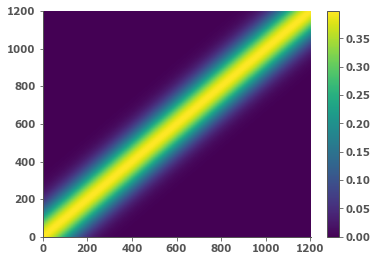

In [31]:
plt.pcolor(process_matrix)
plt.colorbar()
plt.show()

In [36]:
sps.norm(loc=0, scale=1).pdf([-1,-0.5,0,0.5,1])

array([0.24197072, 0.35206533, 0.39894228, 0.35206533, 0.24197072])

In [41]:
post

,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26
0.00,0.000833,9.937079e-04,1.303862e-03,1.482604e-03,1.611838e-03,1.715206e-03,1.802800e-03,1.525393e-03,1.644115e-03,2.104519e-03,2.133658e-03,2.581701e-03,2.558670e-03,2.164529e-03,1.872822e-03,1.972316e-03,2.046232e-03,2.109749e-03,2.166508e-03,2.217963e-03
0.01,0.000833,1.022814e-03,1.345000e-03,1.530614e-03,1.664676e-03,1.771819e-03,1.862555e-03,1.578344e-03,1.700114e-03,2.172890e-03,2.204426e-03,2.663813e-03,2.641982e-03,2.238519e-03,1.938361e-03,2.039714e-03,2.115787e-03,2.181287e-03,2.239853e-03,2.292957e-03
0.02,0.000833,1.051653e-03,1.386010e-03,1.578578e-03,1.717520e-03,1.828474e-03,1.922377e-03,1.631512e-03,1.756298e-03,2.241284e-03,2.275282e-03,2.745813e-03,2.725273e-03,2.312723e-03,2.004212e-03,2.107353e-03,2.185561e-03,2.253037e-03,2.313404e-03,2.368151e-03
0.03,0.000833,1.080175e-03,1.426821e-03,1.626421e-03,1.770289e-03,1.885084e-03,1.982176e-03,1.684822e-03,1.812589e-03,2.309601e-03,2.346121e-03,2.827574e-03,2.808415e-03,2.387031e-03,2.070283e-03,2.175139e-03,2.255458e-03,2.324895e-03,2.387056e-03,2.443439e-03
0.04,0.000833,1.108325e-03,1.467367e-03,1.674065e-03,1.822901e-03,1.941564e-03,2.041863e-03,1.738199e-03,1.868908e-03,2.377739e-03,2.416838e-03,2.908970e-03,2.891278e-03,2.461335e-03,2.136482e-03,2.242978e-03,2.325379e-03,2.396762e-03,2.460704e-03,2.518714e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,0.000833,9.599246e-08,3.417568e-13,2.038921e-18,2.974370e-23,1.564492e-27,3.270372e-31,1.097359e-33,2.485236e-37,5.266764e-41,1.832938e-42,2.227487e-44,2.060798e-44,7.435938e-44,2.303258e-44,2.435705e-46,6.783705e-48,3.965924e-49,4.104354e-50,6.618587e-51
11.97,0.000833,9.140056e-08,3.188027e-13,1.869567e-18,2.668807e-23,1.372724e-27,2.817652e-31,9.333229e-34,2.078195e-37,4.340076e-41,1.503393e-42,1.817038e-44,1.684674e-44,6.093908e-44,1.880539e-44,1.969840e-46,5.448079e-48,3.168604e-49,3.266370e-50,5.251456e-51
11.98,0.000833,8.693509e-08,2.971459e-13,1.713480e-18,2.394180e-23,1.204285e-27,2.427149e-31,7.936333e-34,1.737389e-37,3.575470e-41,1.232758e-42,1.481812e-44,1.376831e-44,4.992783e-44,1.534992e-44,1.592631e-46,4.374148e-48,2.530827e-49,2.598696e-50,4.165456e-51
11.99,0.000833,8.259789e-08,2.767277e-13,1.569663e-18,2.147382e-23,1.056358e-27,2.090378e-31,6.747040e-34,1.452112e-37,2.944770e-41,1.010565e-42,1.208100e-44,1.124940e-44,4.089558e-44,1.252606e-44,1.287292e-46,3.510889e-48,2.020822e-49,2.066878e-50,3.303040e-51
